# Quantum Ensemble as Simple Averaging (Section 4.3)
### Experiments - Data in Table 1, Results Figure 4

This notebook shows in details that the Quantum Ensemble algorithm is able to reproduce the average of multiple cosine classifiers with just one implementation of the quantum cosine classifier.

Import pakages and functions

In [1]:
%matplotlib inline

import sys
sys.path.insert(1, '../')

from Utils import *
from modeling import *

c:\users\anton\appdata\local\programs\python\python37\lib\site-packages\matplotlib\__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


#### Custom dataset and results of (classical) cosine classifier

In [2]:
# Load data without normalisation
X_data, Y_data, x_test = load_data_custom(normalize = False)

# Create table as shown in the paper (Table 1)
data = pd.DataFrame(X_data, columns = [r'$X_1$', r'$X_2$'])

# Extract the value of the target variable as integer
y = [c[1] for c in Y_data]

# Compute the cosine distance between the training points and the test point
dist = [cosine_similarity([x], [x_test])[0][0] for x in X_data]

# Compute the value of the cosine distance classifier
# of the four training points from the test point
p = [cosine_classifier(x, x_test)[0][0] for x in X_data]

# Extract the probabilities for the test point to be classified in class 
# 1 according to the (classical) cosine classifies Equation (16)
probs = []
for i,j in zip(y,p):
    if i == 0:
        probs.append(1-j)
    else:
        probs.append(j)

# Create dataset as in paper (Table 1)
probs = np.array(probs)

# Rename columns
data[r'$y$'] = np.array(y)
data[r'$d($$\cdot$$, $ $\tilde{x})$'] = np.round(dist,2)
data[r'$P($$\tilde{y}$$=1$$|b$ $)$'] = probs

# Rename rows
data.index = [r'$x_1$', r'$x_2$', r'$x_3$', r'$x_4$',]

#Visualize dataset
data

,$X_1$,$X_2$,$y$,"$d($$\cdot$$, $ $\tilde{x})$",$P($$\tilde{y}$$=1$$|b$ $)$
$x_1$,1,3,0,0.89,0.10
$x_2$,-2,2,1,0.00,0.50
$x_3$,3,0,0,0.71,0.25
$x_4$,3,1,1,0.89,0.90


#### Quantum version of the cosine classifier

In [3]:
# Load normalised data
X_data, Y_data, x_test = load_data_custom()

#### Visualisation of the quantum circuit

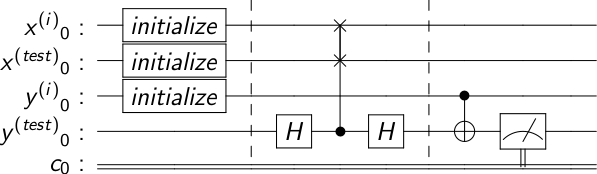

In [4]:
quantum_cosine = cos_classifier(X_data[0], x_test, Y_data[0] )
quantum_cosine.draw(output='latex', scale=.5)

Implementation of the four quantum cosine classifiers: for each training point in X_data we execute the quantum cosine classifier to compute the prediction of the target variable for the test point $\tilde{x}$. Thus, given the measurements of the quantum circuts, we retrieve the probabilities with the function retrieve_proba.

In [5]:
qc1 = cos_classifier(X_data[0], x_test, Y_data[0] )
r1 = exec_simulator(qc1)
r1 = retrieve_proba(r1) 

qc2 = cos_classifier(X_data[1], x_test, Y_data[1])
r2 = exec_simulator(qc2)
r2 = retrieve_proba(r2)

qc3 = cos_classifier(X_data[2], x_test, Y_data[2])
r3 = exec_simulator(qc3)
r3 = retrieve_proba(r3)

qc4 = cos_classifier(X_data[3], x_test, Y_data[3])
r4 = exec_simulator(qc4)
r4 = retrieve_proba(r4)

out = [r1, r2, r3, r4]

We compute the average of the predictions provided by the four quantum cosine classifiers that correspond to the theoretical ensemble prediction, using simple averaging as aggregation strategy.

In [6]:
p0 = [p[0] for p in out]
p1 = [p[1] for p in out]
r_avg = [np.mean(p0), np.mean(p1)]
# print(np.mean(p0), np.mean(p1))

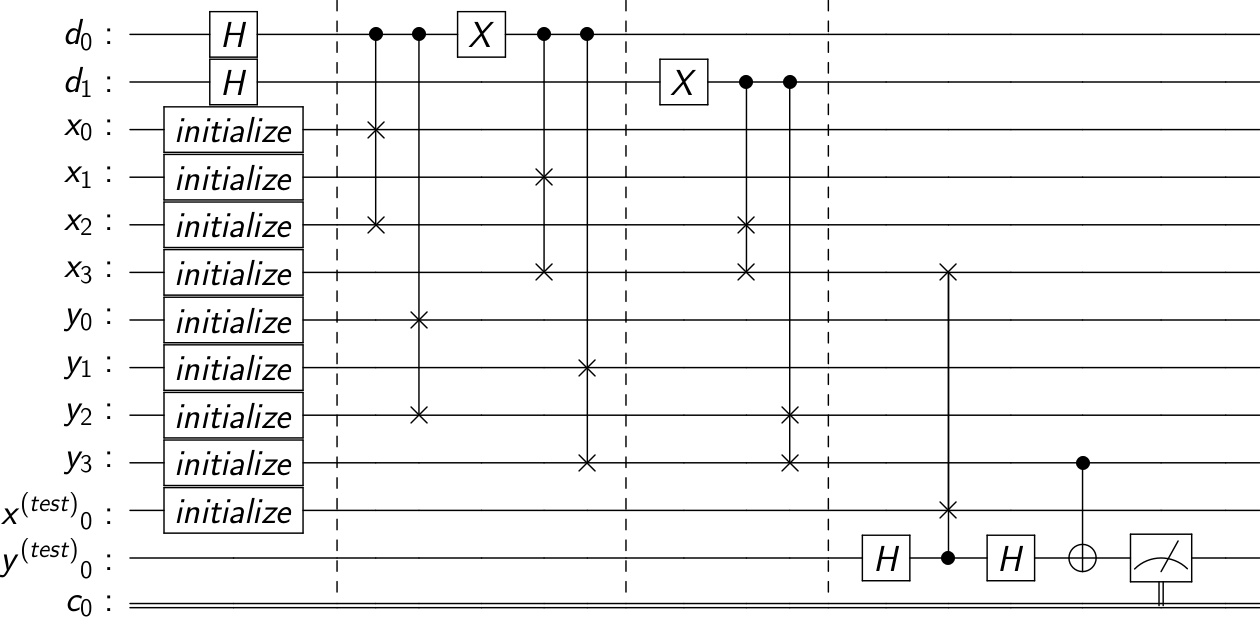

In [7]:
qc = ensemble_fixed_U(X_data, Y_data, x_test)
qc.draw(output='latex')

In [8]:
r = exec_simulator(qc, n_shots=8192)
r_ens = retrieve_proba(r)
print(r_ens)

[0.563720703125, 0.436279296875]


In [9]:
# collect the results
output_simulator = [r1, r2, r3, r4, r_avg, r_ens]

data_pred = pd.DataFrame(output_simulator, 
                         columns=['p0', 'p1'], index=['qc1','qc2','qc3','qc4','AVG','Ensemble'])
data_pred
# data_pred.to_csv('output/sim_results.csv', index=False)

,p0,p1
qc1,0.897217,0.102783
qc2,0.498413,0.501587
qc3,0.757690,0.242310
qc4,0.103027,0.896973
AVG,0.564087,0.435913
Ensemble,0.563721,0.436279


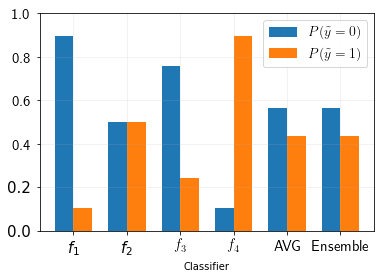

In [10]:
plot_cls(output_simulator, title= '', file='SIM_prediction')

Conclusion: the probability provided by the quantum cosine classifier are pretty much the same to the classical cosine classifier. Furthermore the average of the four classifier is almost the same to the ensemble prediction where it is required only one execution of the cosine classifier

##### In order to perform the same computation on real device it is necessary to load an IBMQ account and to use the function $\text{run_real_device}$ instead of $\text{exec_simulator}$

In [11]:
# Execution on real device
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
provider.backends()
backend_16 = provider.get_backend('ibmq_16_melbourne')
backend_5 = provider.get_backend('ibmq_rome')

def run_real_device(qc, backend, shots=8192):
    job = execute(qc, backend, shots=shots)
    results = job.result()
    r = results.get_counts(qc)
    return r